In [1]:
import numpy as np

from dataclasses import replace

from matplotlib import pyplot as plt

from pulser.channels.dmm import DMM
from pulser.devices import AnalogDevice
from pulser.register import Register
from pulser.register.register_layout import RegisterLayout
from pulser.register.mappable_reg import MappableRegister
from pulser.register.weight_maps import DetuningMap
from pulser.sampler import sampler
from pulser.sequence import Sequence
from pulser.pulse import Pulse
from pulser.waveforms import ConstantWaveform, RampWaveform

In [2]:
trap_coordinates = [(0.0, 0.0), (0.0, 5.0), (5.0, 0.0), (5.0, 5.0)]
weights_1 = [1.0, 0.5, 0.5, 0]  # between 0 and 1
weights_2 = [1.0, 1.0, 1.0, 0]  # between 0 and 1

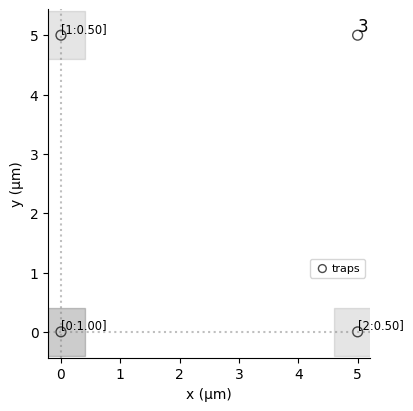

In [3]:
register_layout = RegisterLayout(trap_coordinates)
detuning_map = register_layout.define_detuning_map(
    {i: weights_1[i] for i in range(4)}  # mapping between trap ids and weights
)

map_reg = MappableRegister(register_layout)
det_map_from_map_reg = map_reg.define_detuning_map(
    {i: weights_1[i] for i in range(4)}  # mapping between trap ids and weights
)

register = Register.from_coordinates(
    trap_coordinates, center=False, prefix="q"
)
det_map_from_reg = register.define_detuning_map(
    {
        f"q{i}": weights_1[i] for i in range(4)
    }  # mapping between qubit ids and weights
)

detuning_map.draw(labels=[0, 1, 2, 3])
assert detuning_map == det_map_from_map_reg
assert detuning_map == det_map_from_reg

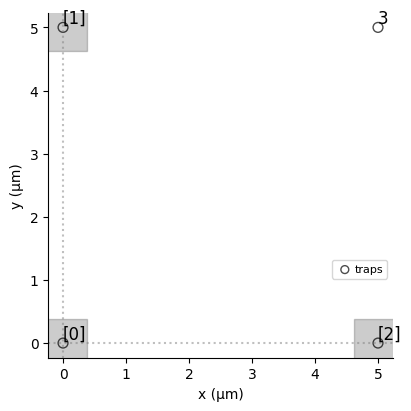

In [4]:
detuning_map_2 = register_layout.define_detuning_map(
    {i: weights_2[i] for i in range(4)}  # mapping between trap ids and weights
)
detuning_map_2.draw(labels=[0, 1, 2, 3])

In [5]:
dmm = DMM(
    clock_period=4,
    min_duration=16,
    max_duration=2**26,
    mod_bandwidth=8,
    bottom_detuning=-2 * np.pi * 20,  # detuning between 0 and -20 MHz
    total_bottom_detuning=-2 * np.pi * 2000,  # total detuning
)

In [6]:
mock_device = replace(
    AnalogDevice.to_virtual(),
    dmm_objects=(dmm, DMM()),
    reusable_channels=True,
)
print(mock_device.dmm_channels)

{'dmm_0': DMM(addressing='Global', max_abs_detuning=None, max_amp=0, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=67108864, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=None, propagation_dir=None, bottom_detuning=-125.66370614359172, total_bottom_detuning=-12566.370614359172), 'dmm_1': DMM(addressing='Global', max_abs_detuning=None, max_amp=0, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=1, min_duration=1, max_duration=100000000, min_avg_amp=0, mod_bandwidth=None, custom_phase_jump_time=None, eom_config=None, propagation_dir=None, bottom_detuning=None, total_bottom_detuning=None)}


In [ ]:
import pulser
seq = Sequence(register, pulser.DigitalAnalogDevice)
seq.config_detuning_map(detuning_map, "dmm_0")
print(seq.declared_channels)

{'dmm_0': DMM(addressing='Global', max_abs_detuning=None, max_amp=0, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=67108864, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=None, propagation_dir=None, bottom_detuning=-125.66370614359172, total_bottom_detuning=-12566.370614359172)}


In [8]:
seq.config_detuning_map(detuning_map_2, "dmm_0")
print(seq.declared_channels.keys())

dict_keys(['dmm_0', 'dmm_0_1'])


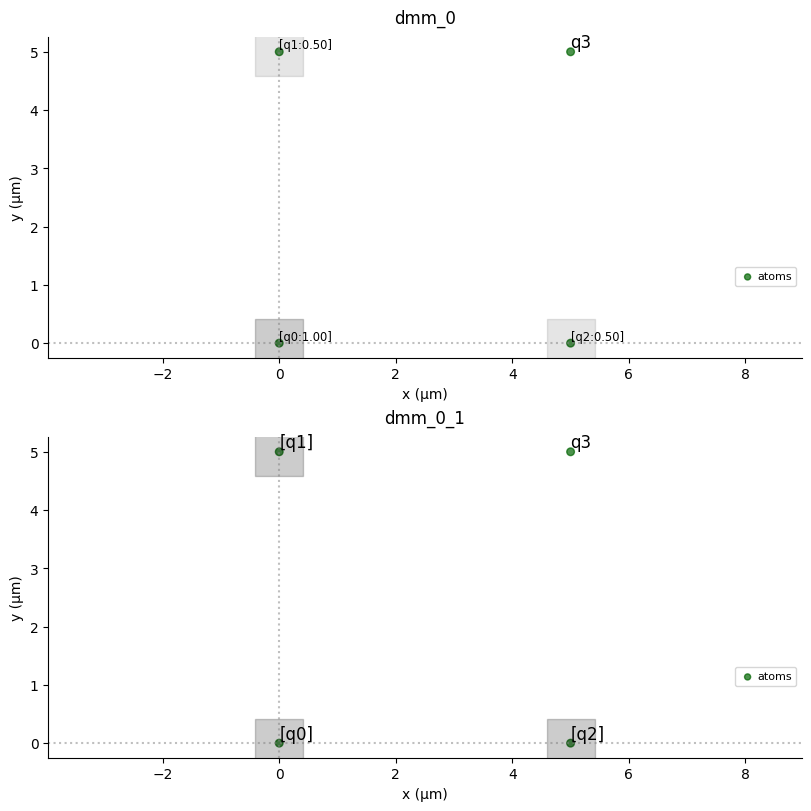

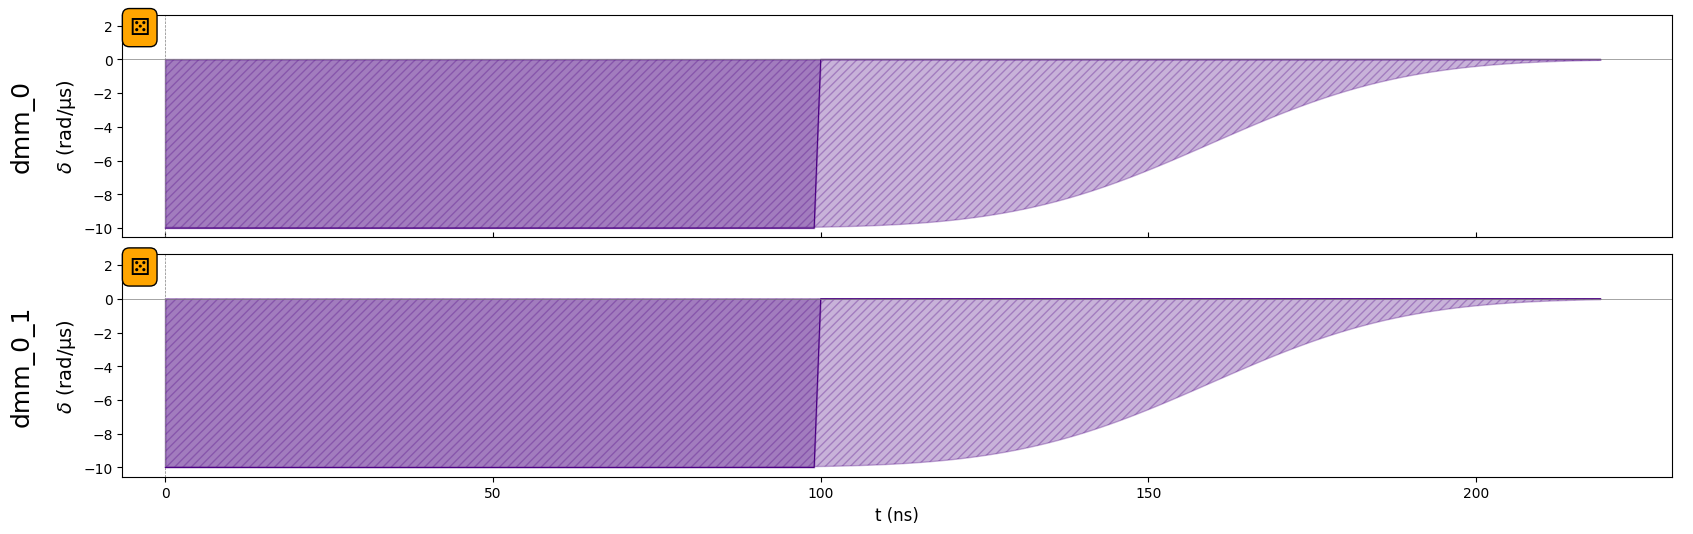

In [9]:
seq.add_dmm_detuning(ConstantWaveform(100, -10), "dmm_0")
seq.add_dmm_detuning(ConstantWaveform(100, -10), "dmm_0_1")
seq.draw(draw_detuning_maps=True)

In [10]:
seq.declare_channel("ryd_glob", "rydberg_global")

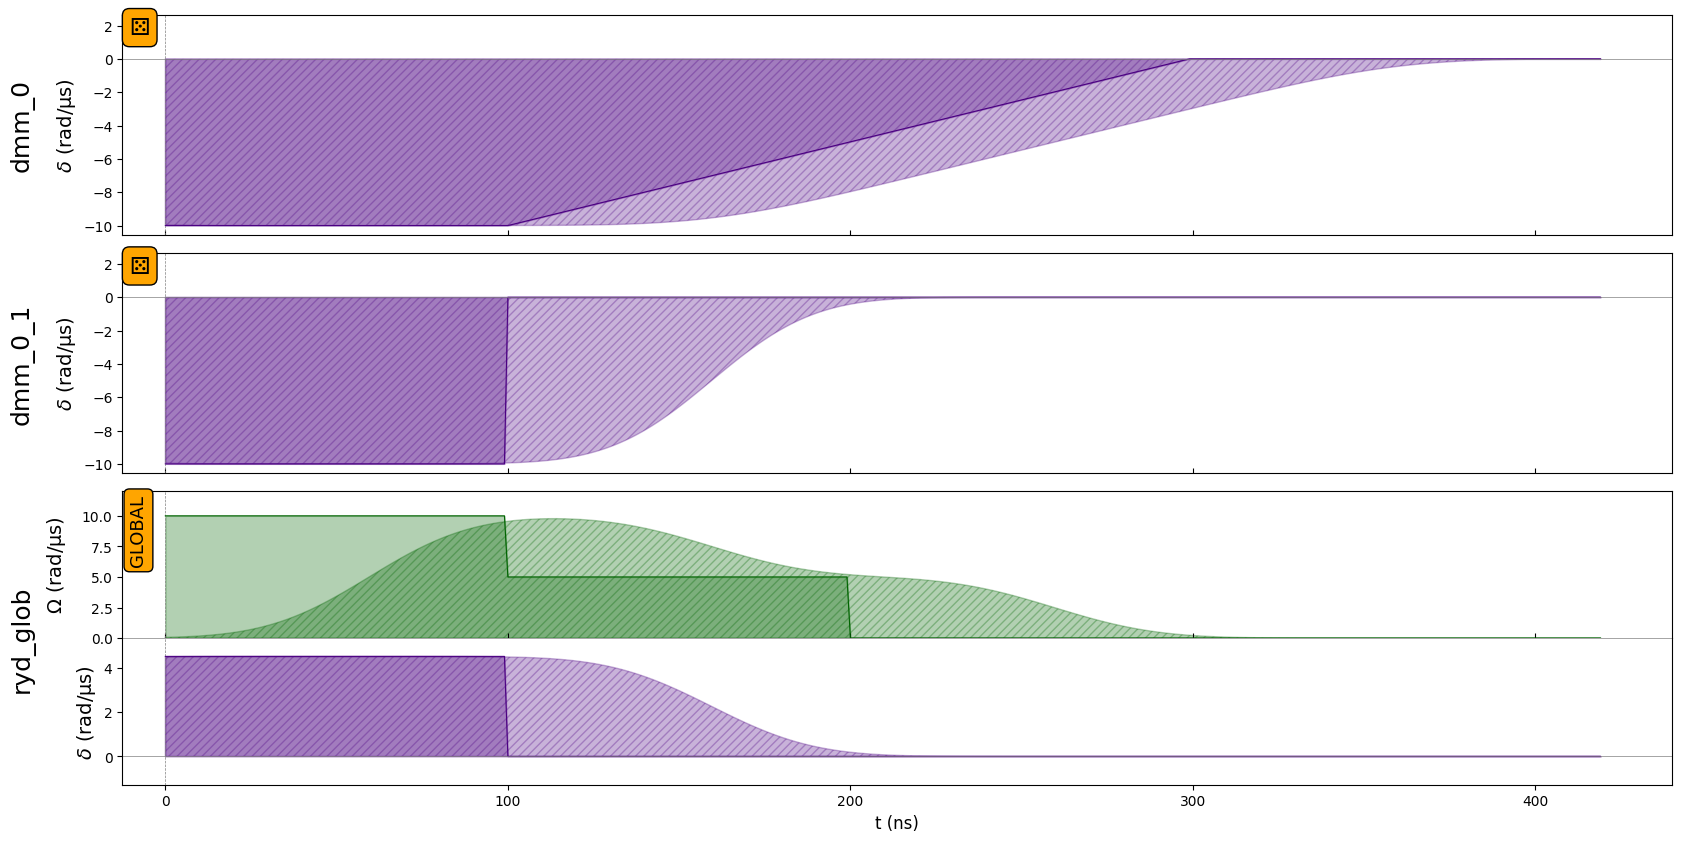

In [11]:
seq.add(
    Pulse.ConstantPulse(100, 10, 4.5, 0), "ryd_glob", protocol="no-delay"
)  # added at the beginning with protocol "no delay"
seq.add_dmm_detuning(RampWaveform(200, -10, 0), "dmm_0")  # added at t=100
seq.add(
    Pulse.ConstantPulse(100, 5, 0, 0), "ryd_glob", protocol="no-delay"
)  # added at t=100
seq.draw()

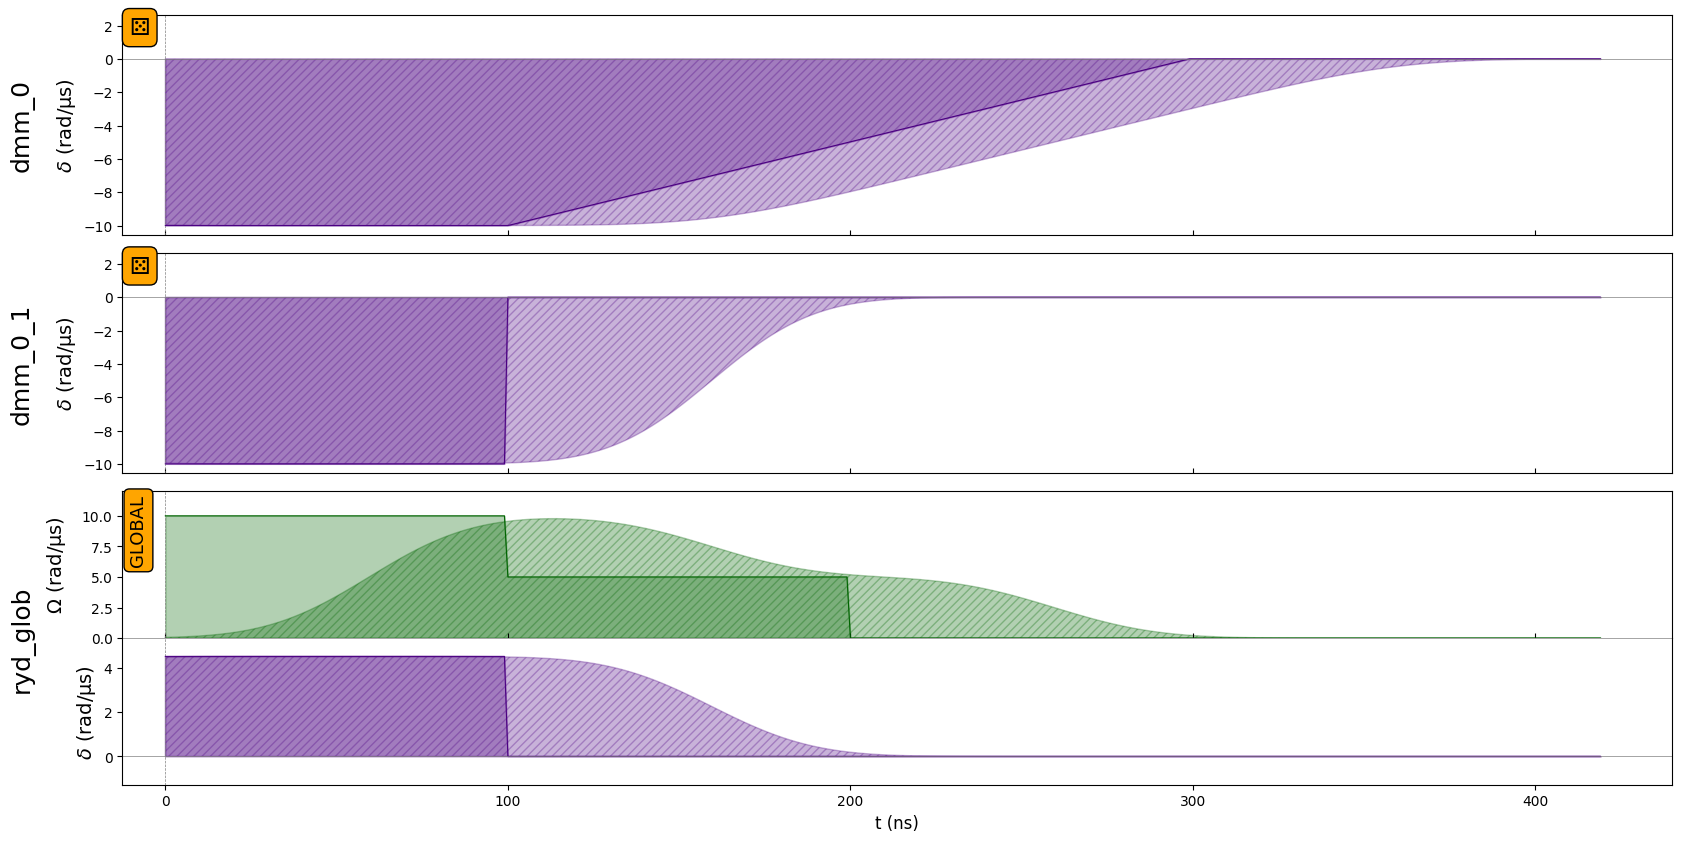

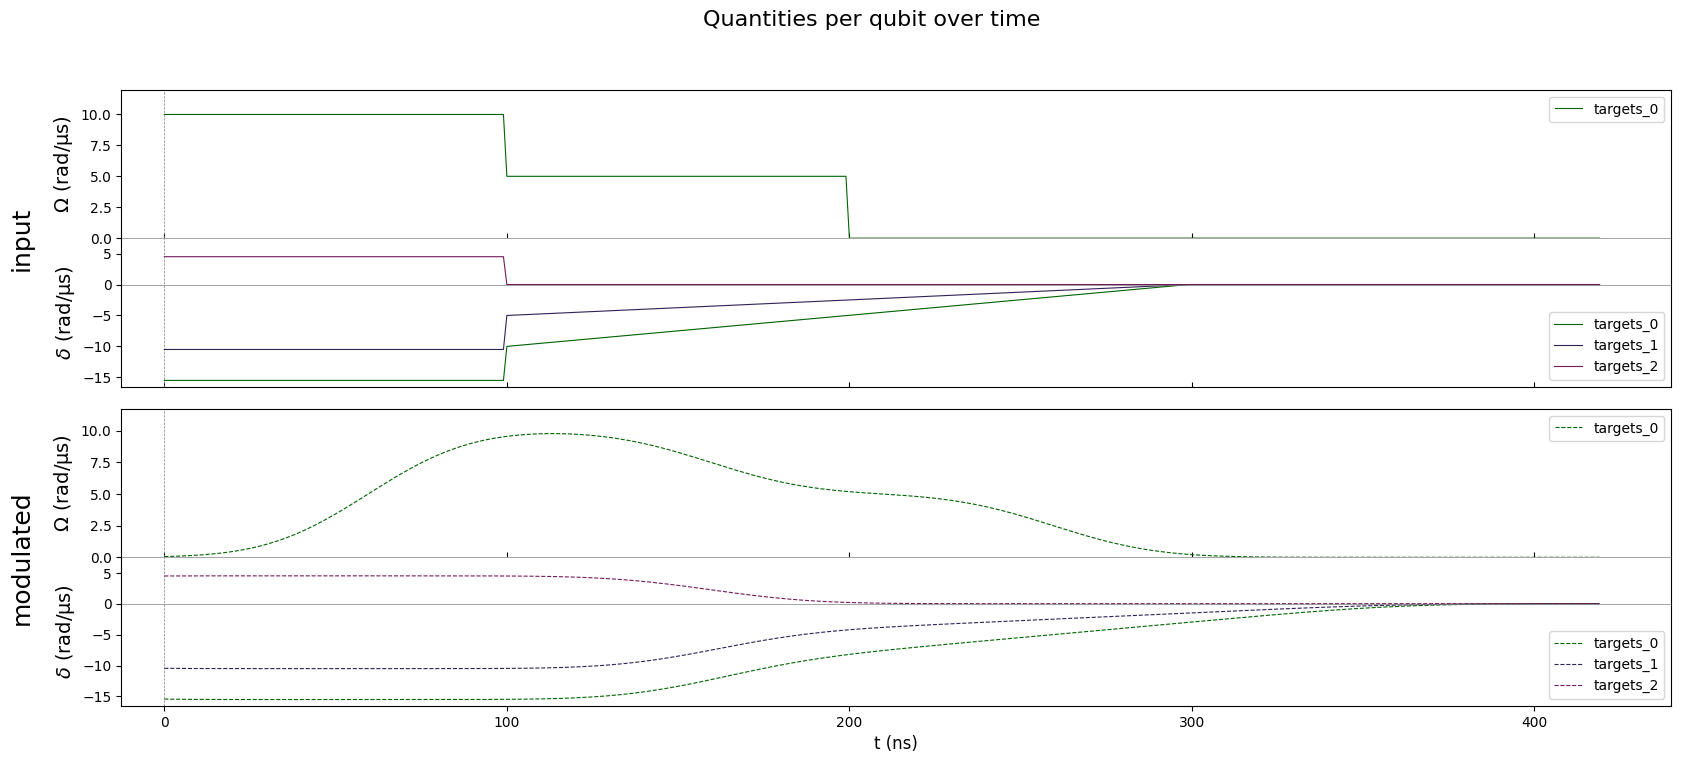

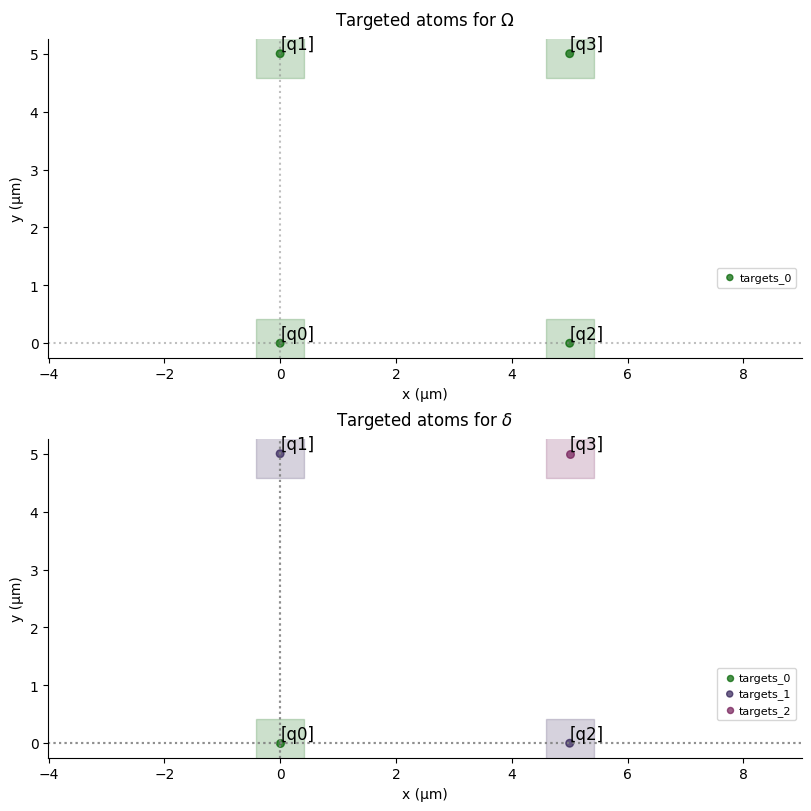

In [12]:
seq.draw(
    mode="input+output",  # "input" only shows input signals, "input+output"
    draw_qubit_det=True,
    draw_qubit_amp=True,
)

In [13]:
s_readable = seq.to_abstract_repr(
    json_dumps_options={"indent": 1},
    seq_name="Sequence_with_defaults",
)
with open("dmmtest1.json", "w") as f:
    f.write(s_readable)